In [1]:
##### MODIFY HERE #####
# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# specify site name
site_name = 'Wolverine'
# path where figures will be saved
figures_out_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/' + site_name + '/figures/' 
# path to snowline files
sl_est_path = figures_out_path +'../imagery/snowlines/' 
# path where filtered snowlines will be saved
out_path = sl_est_path 
# path to USGS mass balance data/ELA csvs 
# If no USGS files, set usgs_path=None
usgs_path = None #'/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
#######################

# import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from time import mktime
import seaborn as sns
from scipy.stats import median_abs_deviation as mad

In [3]:
# -----Compile snowline files
sl_est_fns = glob.glob(sl_est_path + '*snowline.csv')
# compile all snowline files into one DataFrame
sl_est_full = pd.DataFrame()
for fn in sl_est_fns:
    # read file
    if 'csv' in fn:
        sl_est = pd.read_csv(fn)
    elif 'pkl' in fn:
        sl_est = pickle.load(open(fn, 'rb'))
    # concatenate to df
    sl_est_full = pd.concat([sl_est_full, sl_est])
sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime']) # renumber, sort by date

# -----Reformat snowlines dataframes
# unify datetime datatypes
sl_est_full['datetime'] = sl_est_full['datetime'].astype('datetime64[ns]')
# add month column
sl_est_full['month'] = [x.month for x in sl_est_full['datetime']]
# add year column
sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]

# extract all unique years
years = np.unique(sl_est_full['year'])
# set datetime as index
sl_est_full.index = sl_est_full['datetime']
sl_est_full

,Unnamed: 0,study_site,datetime,snowlines_coords_X,snowlines_coords_Y,CRS,snowlines_elevs_m,snowlines_elevs_median_m,SCA_m2,AAR,dataset,geometry,month,year
datetime,,,,,,,,,,,,,,
2013-06-11 15:10:02,0,Wolverine,2013-06-11 15:10:02,[],[],EPSG:32606,480.0,480.000000,15418800.0,1.000000,Landsat,[],6,2013
2013-06-27 15:09:59,0,Wolverine,2013-06-27 15:09:59,"[394260.0, 394245.0, 394245.0, 394230.0, 39421...","[6697185.0, 6697170.0, 6697140.0, 6697125.0, 6...",EPSG:32606,"[array(978.70251651), array(977.99387455), arr...",993.654908,13017600.0,0.988586,Landsat,"LINESTRING (394260 6697185, 394245 6697170, 39...",6,2013
2013-07-13 15:10:01,0,Wolverine,2013-07-13 15:10:01,"[394260.0, 394275.0, 394290.0, 394320.0, 39435...","[6697575.0, 6697560.0, 6697545.0, 6697545.0, 6...",EPSG:32606,"[array(1042.17195791), array(1037.81397161), a...",1029.001151,13248900.0,0.886540,Landsat,"LINESTRING (394260 6697575, 394275 6697560, 39...",7,2013
2013-07-29 15:10:01,0,Wolverine,2013-07-29 15:10:01,"[393885.0, 393900.0, 393930.0, 393945.0, 39396...","[6698280.0, 6698295.0, 6698295.0, 6698280.0, 6...",EPSG:32606,"[array(1160.14715312), array(1164.20053352), a...",1133.846117,10959300.0,0.710817,Landsat,"LINESTRING (393885 6698280, 393900 6698295, 39...",7,2013
2013-08-23 15:03:53,0,Wolverine,2013-08-23 15:03:53,"[394215.0, 394185.0, 394170.0, 394140.0, 39412...","[6696330.0, 6696510.0, 6696525.0, 6696525.0, 6...",EPSG:32606,"[array(928.44591033), array(937.02399849), arr...",1200.518965,9895500.0,0.695886,Landsat,"LINESTRING (394215 6696330, 394185 6696510, 39...",8,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-23 15:18:47,0,Wolverine,2022-10-23 15:18:47,[],[],EPSG:32606,470.0,470.000000,15353800.0,0.999642,Sentinel-2_SR,[],10,2022
2022-10-28 15:18:30,0,Wolverine,2022-10-28 15:18:30,[],[],EPSG:32606,470.0,470.000000,15394700.0,0.999078,Sentinel-2_SR,[],10,2022
2022-10-28 15:18:30,0,Wolverine,2022-10-28 15:18:30,[],[],EPSG:32606,470.0,470.000000,15408400.0,0.999961,Sentinel-2_TOA,[],10,2022


#### For each year, take moving median, shift into normalized space, fit piecewise polynomial

In [4]:
from scipy.interpolate import interp1d

In [69]:
# Define function to calculate running median
from collections import deque
from bisect import insort, bisect_left
from itertools import islice
def running_median(x, N):
    '''
    Calculate running median. 
    Adapted from Peter Otten: https://stackoverflow.com/questions/37671432/how-to-calculate-running-median-efficiently
    
    Parameters
    ----------
    x: numpy.array
        input array of values
    N: int or float
        window size over which to calculate running median
        
    Returns
    ----------
    x_moving_median: np.array
        moving median of x with a window of N
    '''
    seq = iter(x)
    d = deque()
    s = []
    x_moving_median = []
    for item in islice(x, N):
        d.append(item)
        insort(s, item)
        x_moving_median.append(s[len(d)//2])
    m = N // 2
    for item in seq:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        x_moving_median.append(s[m])
    # adjust values to original x where median is invalid
    x_moving_median = np.concatenate((x[0:int((N-1)/2)], 
                                      x_moving_median[int(N*2)-1:], 
                                      x[-int((N-1)/2):]))
    return x_moving_median

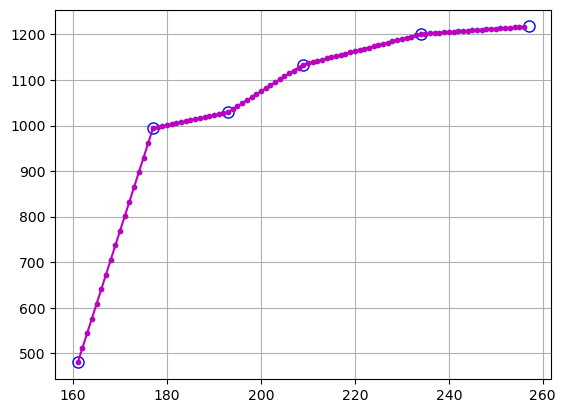

In [74]:
year = 2013
sl_est_year = sl_est_full.loc[sl_est_full['year']==year]
# create array of days
days = (np.arange(np.nanmin(sl_est_year['datetime']), np.nanmax(sl_est_year['datetime']), 
                 dtype='datetime64[D]') - np.datetime64(str(year)+'-01-01')).astype(int)
sl_est_year_days = (sl_est_year['datetime'].values.astype('datetime64[D]') 
                    - np.datetime64(str(year)+'-01-01')).astype(int)
# interpolate snowline for year at each day
f = interp1d(sl_est_year_days, sl_est_year['snowlines_elevs_median_m'])
sl_interp = f(days)
# fit moving median 
N = 5 # window size
sl_interp_med = running_median(sl_interp, N)
len(days), len(sl_interp_med)

# grab minimum and maximum values


In [87]:
# Define function to center peaks from different curves
# From: https://stackoverflow.com/questions/74500739/align-the-peaks-of-multiple-curves
def centralize(v):
    return np.concatenate((v[len(v) % 2::2], v[::-2]))

def shift_x(v, max_position):
    start = max_position - v.argmax()
    end = start + len(v)
    x = np.arange(start, end)
    return x


100
100
100
100
100
100
100
100
100
100


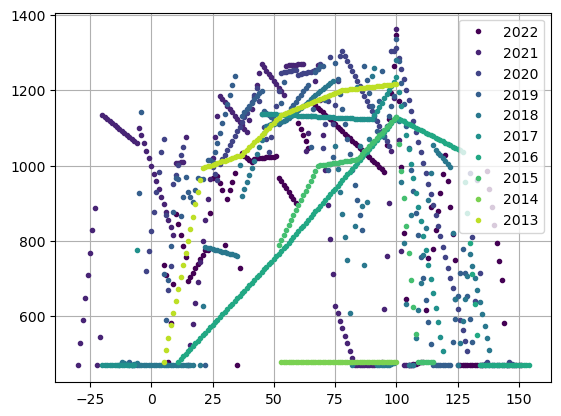

In [123]:
# ----Set up figure
# fig = plt.figure(figsize=(20, 6))
# plt.rcParams.update({'font.size':18, 'font.sans-serif':'Arial'})
# spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2.5])
# ax1 = fig.add_subplot(spec[0, 0])
# ax1.set_xlabel('Month')
# ax1.set_ylabel('Median snowline elevations [m]')
# ax1.grid()
# ax2 = fig.add_subplot(spec[0, 1])
# ax2.set_xlabel('Date')
# ax2.grid()

fig = plt.figure()
plt.style.use('default')
col = plt.cm.viridis

# -----Loop through years
for i, year in enumerate(np.flip(years)):
    # subset snowlines by year
    sl_est_year = sl_est_full.loc[sl_est_full['year']==year]
    # grab day of year (DOY) for each date
    sl_est_year_DOY = (sl_est_year['datetime'].values.astype('datetime64[D]') 
                         - np.datetime64(str(year)+'-01-01')).astype(int)
    # create array of days between minimum and maximum DOY
    days = np.arange(np.nanmin(sl_est_year_DOY), np.nanmax(sl_est_year_DOY)).astype(int)
    # interpolate snowline at each day
    f = interp1d(sl_est_year_DOY, sl_est_year['snowlines_elevs_median_m'])
    sl_interp = f(days)
    # calculate moving median 
    # N = 5 # window size
    # sl_interp_med = running_median(sl_interp, N)
    
    # shift into "normalized space" where maximum snowline elevations are aligned for all years
    Imax = np.argwhere(sl_interp==np.nanmax(sl_interp))[-1][0]
    Imins = [np.argwhere(sl_interp[0:Imax]==np.nanmin(sl_interp[0:Imax]))[-1][0], # minimum before increasing to max sl
             np.argwhere(sl_interp[Imax:]==np.nanmin(sl_interp[Imax:]))[0][0] + Imax] # minimum after max sl
    max_position = 100
    min_positions = [0, 200]
    # shift days so max positions are aligned
    days_new = days + (max_position - days[Imax])
    # shift days so min positions are aligned
    days_new[0:Imax] = [
    
    
    plt.plot(days_new, sl_interp, '.', color=col(i/len(years)), label=year)
    
plt.grid()
plt.legend(loc='best')
plt.show()

In [117]:
np.argwhere(sl_interp[0:Imax]==np.nanmin(sl_interp[0:Imax]))

array([[9]])

In [ ]:
# -----Filter points using median and IQR trend
# med = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m']) for month in months])
# # mean = np.array([np.nanmean(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m']) for month in months])
# # std = np.array([np.nanstd(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m']) for month in months])
# # MAD = np.array([mad(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'], nan_policy='omit') for month in months])
# IQR_min = np.array([iqr(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'],
#                         rng=(25,50), nan_policy='omit') for month in months])
# # if minimum goes below the glacier elevation range, make it the minimum elevation
# IQR_min[IQR_min < np.nanmin(sl_est_full['snowlines_elevs_median_m'])]== np.nanmin(sl_est_full['snowlines_elevs_median_m'])
# IQR_max = np.array([iqr(sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'],
#                         rng=(50,75), nan_policy='omit')*3 for month in months])
# # if the IQR_max = IQR_min, increase the max value by 10% the elevation range
# IQR_max[IQR_max==IQR_min] = (np.nanmax(sl_est_full['snowlines_elevs_median_m']) - np.nanmin(sl_est_full['snowlines_elevs_median_m']))*0.1

# sl_est_full_filt = sl_est_full.copy() # filtered dataframe
# n_filt = 0 # count number of filtered points
# for j, month in enumerate(months):
#     Ifilt = np.ravel(np.argwhere((sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'] > med[j]+IQR_max[j]).values |
#                     ((sl_est_full.loc[sl_est_full['month']==month]['snowlines_elevs_median_m'] < med[j]-IQR_min[j]).values)))
#     n_filt = n_filt + len(Ifilt)
#     if len(Ifilt)>0:
#         sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month']==month) & (sl_est_full_filt['snowlines_elevs_median_m'] > med[j]+IQR_max[j]))
#         sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month']==month) & (sl_est_full_filt['snowlines_elevs_median_m'] < med[j]-IQR_min[j]))

#     # removed points
#     ax1.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['month'],
#              sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowlines_elevs_median_m'],
#              'x', markersize=5, color='#969696', label='_nolegend_')
#     ax2.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['datetime'],
#              sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowlines_elevs_median_m'],
#              'x', markersize=5, color='#969696')

# # -----Determine annual ELAs
# # add years column
# sl_est_full_filt['year'] = [x.year for x in sl_est_full_filt['datetime']]
# # grab all unique years
# years = np.unique(sl_est_full_filt['year'].dropna())
# # initialize dataframe for ELAs
# ELAs_df = pd.DataFrame()
# # loop through years, save maximum median snowline elevation and date of observation
# for year in years:
#     sl_est_year = sl_est_full_filt.loc[sl_est_full_filt['year']==year]
#     ELA, dt = sl_est_year.loc[sl_est_year['snowlines_elevs_median_m']==np.max(sl_est_year['snowlines_elevs_median_m'])][['snowlines_elevs_median_m', 'datetime']].values[0]
#     df = pd.DataFrame({'ELA_m': ELA,
#                        'datetime':dt},
#                       index=[0])
#     ELAs_df = pd.concat([ELAs_df, df])
# ELAs_df = ELAs_df.reset_index(drop=True)

# # -----Plot
# ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
# ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
# # plot minimum elevation
# elev_min = np.nanmin(sl_est_full['snowlines_elevs_median_m'])
# ax1.plot([ax1.get_xlim()[0], ax1.get_xlim()[1]],
#          [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
# ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]],
#          [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
# # range of acceptable values
# ax1.fill_between(months, med-IQR_min, med+IQR_max, color='#4eb3d3', label='Acceptable range')
# # monthly median
# ax1.plot(months, med, '-b', label='Monthly median')
# # filtered time series
# ax1.plot(sl_est_full_filt['month'], sl_est_full_filt['snowlines_elevs_median_m'], '.k', markersize=10, label='Filtered time series')
# ax2.plot(sl_est_full_filt['datetime'], sl_est_full_filt['snowlines_elevs_median_m'], '.k', markersize=10)
# # ELAs
# ax2.plot(ELAs_df['datetime'], ELAs_df['ELA_m'], 's', color='b', markersize=10)
# # dummy points for legend
# ax1.plot(0, 0, 'x', markersize=5, color='#969696', label='Removed points')
# ax1.plot(0, 0,  's', color='b', markersize=10, label='ELA')
# # optional: plot USGS ELA estimates
# if usgs_path:
#     usgs_fn = usgs_path + site_name+'/Output_'+site_name+'_Glacier_Wide_solutions_calibrated.csv'
#     usgs_file = pd.read_csv(usgs_fn)
#     ELA = usgs_file['ELA_m']
#     ELA_date = usgs_file['Ba_Date'].astype(np.datetime64)
#     ax1.plot(0,0, 's', markerfacecolor='None', markeredgecolor='orange',
#              ms=10, markeredgewidth=2, label='USGS ELA')
#     ax2.plot(ELA_date, ELA, 's', markerfacecolor='None', markeredgecolor='orange',
#              ms=10, markeredgewidth=2, label='_nolegend_')
# # set axis limits
# ax1.set_xticks(np.linspace(months[0], months[-1], num=months[-1]-months[0]+1))
# ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
# ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
# ymin, ymax = (np.nanmin(np.concatenate([sl_est_full['snowlines_elevs_median_m'].values, np.array(med-IQR_min)]))-25,
#               np.nanmax(np.concatenate([sl_est_full['snowlines_elevs_median_m'].values, np.array(med+IQR_max)]))+25)
# ax1.set_ylim(ymin, ymax)
# ax2.set_ylim(ymin, ymax)
# # add legend to figure
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=len(labels))

# plt.show()
# print('Number of removed points = '+str(n_filt))

# # -----Save figure
# min_date = str(np.nanmin(sl_est_full['datetime']))[0:10].replace('-','')
# max_date = str(np.nanmax(sl_est_full['datetime']))[0:10].replace('-','')
# fig_fn = figures_out_path + min_date + '_'+ max_date + '_' + site_name + '_filtered_snowlines.png'
# fig.savefig(fig_fn, dpi=300, facecolor='w')
# print('figure saved to file: ' + fig_fn)

# # -----Save filtered snowline time series
# sl_fn = min_date + '_' + max_date + '_' + site_name + '_filtered_snowlines.csv'
# sl_est_full_filt = sl_est_full_filt.dropna().drop(['datetime', 'month'], axis=1)
# sl_est_full_filt.to_csv(out_path + sl_fn)
# print('filtered snowlines saved to file: ' + out_path + sl_fn)

# # -----Save ELA times series
# ELAs_fn = min_date + '_' + max_date + '_' + site_name + '_ELAs.csv'
# ELAs_df.to_csv(out_path + ELAs_fn)
# print('ELAs saved to file: ' + out_path + ELAs_fn)
# print(' ')